In [3]:
# Import Libraries and Dependencies
import constrained_optimization
from constrained_optimization.base import*
from constrained_optimization.generate import*

In [6]:
dimX = 100
dimY = 100
dimU = 100

import time
start_time = time.time()
p, q, r, A, b = randQCQP(dimX,dimY,True,True, dimU)
print("--- %s seconds ---" % (time.time() - start_time))


--- 0.019947052001953125 seconds ---


In [5]:
p, q, r, A, b = randQCQPmat(dimX,dimY,True,True, dimU)

--- 77.44616961479187 seconds ---


In [4]:
M_ = 3
N_ = 2
convex_ = False

x_rand = np.random.rand(N_)
q_temp = np.random.rand(M_+1, N_)
p_temp = np.random.rand(M_+1, N_, N_)
if convex_:
    p_temp = np.matmul(p_temp, np.transpose(p_temp, (0,2,1)))
else :
    p_temp = np.maximum(p_temp, np.transpose(p_temp, (0,2,1)))
r_temp = -0.5*np.transpose(x_rand)@p_temp@x_rand - q_temp@x_rand

In [7]:

#start_time = time.time()
#fx, hx, gradf, gradh = toQCQPmat(p, q, r)
#print("--- %s seconds ---" % (time.time() - start_time))
hxs = []
gradhs = []
for i in range(len(hx)):
    temp = lambda x: -1*hx[i](x)
    hxs.append(temp)
    temp = lambda x: -1*gradh[i](x)
    gradhs.append(temp)

NameError: name 'hx' is not defined

In [8]:
fx, hx, gradf, gradh = toQCQP(p, q, r)

In [10]:
prob = co_problem(fx, dimX, hx, None, gradf, gradh, A, b)

x = np.ones(dimX+dimY+dimU)
F_co, J_co = prob.get_parameters(False)
F_co(x)

array([ 2.54426627e+07,  2.54425135e+07,  2.54427070e+07,  2.54426144e+07,
        2.54427723e+07,  2.54426419e+07,  2.54425833e+07,  2.54429227e+07,
        2.54425351e+07,  2.54427596e+07,  2.54425281e+07,  2.54429134e+07,
        2.54421441e+07,  2.54427585e+07,  2.54425973e+07,  2.54429722e+07,
        2.54425077e+07,  2.54428648e+07,  2.54425798e+07,  2.54426198e+07,
        2.54427732e+07,  2.54428370e+07,  2.54426040e+07,  2.54426142e+07,
        2.54424985e+07,  2.54424924e+07,  2.54427362e+07,  2.54426522e+07,
        2.54426629e+07,  2.54424724e+07,  2.54426401e+07,  2.54428294e+07,
        2.54425212e+07,  2.54423945e+07,  2.54423387e+07,  2.54427092e+07,
        2.54429765e+07,  2.54427021e+07,  2.54425283e+07,  2.54425699e+07,
        2.54425549e+07,  2.54427496e+07,  2.54428398e+07,  2.54424297e+07,
        2.54428139e+07,  2.54419947e+07,  2.54425626e+07,  2.54426995e+07,
        2.54425621e+07,  2.54427314e+07,  2.54427014e+07,  2.54425940e+07,
        2.54427192e+07,  

## Adaptive Graal to solve VI

In [11]:
def adaptive_graal(J, F, prox_g, x1, numb_iter=100, phi=1.5, output=False): 
    begin = perf_counter()
    x, x_ = x1.copy(), x1.copy()
    x0 = x + np.random.randn(x.shape[0]) * 1e-9
    Fx = F(x)
    la = phi / 2 * LA.norm(x - x0) / LA.norm(Fx - F(x0))
    rho = 1. / phi + 1. / phi**2
    values = [J(x)]
    time_list = [perf_counter() - begin]
    th = 1

    for i in range(numb_iter):
        x1 = prox_g(x_ - la * Fx, la)
        Fx1 = F(x1)

        n1 = LA.norm(x1 - x)**2
        n2 = LA.norm(Fx1 - Fx)**2
        n1_div_n2 = n1/n2 if n2 != 0 else la*10

        la1 = min(rho * la, 0.25 * phi * th / la * n1_div_n2)
        x_ = ((phi - 1) * x1 + x_) / phi
        if output:
            print (i, la)
        th = phi * la1 / la
        x, la, Fx = x1, la1, Fx1
        values.append(J(x))
        time_list.append(perf_counter() - begin)
    end = perf_counter()

    print("CPU time for aGRAAL:", end - begin)
    return values, x, x_, time_list

## Solver of VI

In [12]:
prox_g = lambda q, eps: np.fmax(q,0)
# starting point
N = 1000
q0 = np.ones(dimX + dimY + dimU)
print(F_co(q0).shape)

(300,)


In [13]:
ans1 = adaptive_graal(J_co, F_co, prox_g, q0, numb_iter=N, phi=1.5, output=False)

CPU time for aGRAAL: 2.3355796999999967


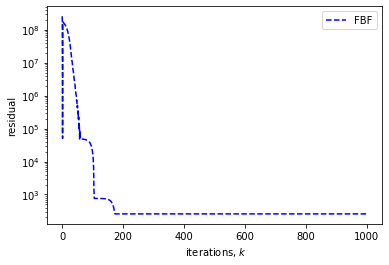

Answer is 256.84550543279755
Answer is [4.60375011e-170 4.64440871e-170 4.59894298e-170 4.61863092e-170
 4.56855189e-170 4.61852139e-170 4.61062025e-170 4.55079344e-170
 4.63234427e-170 4.59650085e-170 4.63929346e-170 4.53706386e-170
 4.71705605e-170 4.59928680e-170 4.61481439e-170 4.53388975e-170
 4.63200031e-170 4.55692997e-170 4.61483246e-170 4.62992342e-170
 4.58302562e-170 4.55509769e-170 4.61105691e-170 4.63401301e-170
 4.63044983e-170 4.63728555e-170 4.58813721e-170 4.61141042e-170
 4.58088658e-170 4.65575578e-170 4.60754181e-170 4.55884326e-170
 4.66503036e-170 4.65878825e-170 4.66739941e-170 4.58577930e-170
 4.52390280e-170 4.60143768e-170 4.62500388e-170 4.62298836e-170
 4.62540968e-170 4.57841780e-170 4.57292268e-170 4.64497784e-170
 4.56982456e-170 4.75398144e-170 4.64073312e-170 4.59453458e-170
 4.63753627e-170 4.58841557e-170 4.59443284e-170 4.62285865e-170
 4.59680060e-170 4.62094799e-170 4.58577360e-170 4.59340898e-170
 4.65322466e-170 4.54215149e-170 4.66930352e-170 4.

In [14]:
plt.plot(ans1[0], '--b', label = 'FBF')

plt.yscale('log')

plt.xlabel(u' iterations, $k$')
plt.ylabel(u'residual')

plt.legend()
#plt.savefig('figures/nash.pdf', bbox_inches='tight')
plt.show()
print("Answer is", ans1[0][-1])
print("Answer is", ans1[2])
print("Answer is", fx(ans1[2][0:dimX]))

In [15]:
ans1[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## Solving the QCQP

In [23]:
from scipy.optimize import minimize
cons = []
for i in range(len(hx)):
    temp = ({'type': 'ineq', 'fun': lambda x: hx[i](x) })
    cons.append(temp)
bnds = []
for i in range(dimX):
    temp = ((0, None))
    bnds.append(temp)
x = np.ones(dimX)
res = minimize(fx, x, method='SLSQP', bounds=bnds, constraints=cons)

In [24]:
print(fx(res['x']))
print(res['x'])
#print("Answer is:", res)

22.478066737252405
[4.34004870e+00 0.00000000e+00 1.38839345e-11 1.40058140e-11
 4.81151999e-13 9.14765367e-12 0.00000000e+00 2.12530896e-11
 3.72929798e-12 7.97988581e-03]
